In [33]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# !python3 --version
# !pip --version

# References:
# https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5


# UNCOMMENT THE BELOW IMPORTS IF YOU ARE NOT USING THE COLAB GPU OR IF YOU GET IMPORT ERRORS

# !pip3 install re 
# !pip3 install matplotlib 
# !pip3 install numpy 
# !pip3 install pandas 
# !pip3 install scikit-learn 
# !pip3 install nltk 
# !pip3 install seaborn


In [34]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
nltk.download('stopwords')
print('Stopwords have finished downloading successfully')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
print('All imports were successful')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Stopwords have finished downloading successfully
All imports were successful


In [37]:
df = pd.read_csv("/train.csv", encoding = "ISO-8859-1")
print('The first 5 elements in the train.csv are:')
print(df.head())

# Getting the number of comments in each category
df_toxic = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
print(df_stats)

The first 5 elements in the train.csv are:
                 id  ... identity_hate
0  0000997932d777bf  ...             0
1  000103f0d9cfb60f  ...             0
2  000113f07ec002fd  ...             0
3  0001b41b1c6bb37e  ...             0
4  0001d958c54c6e35  ...             0

[5 rows x 8 columns]
        category  number_of_comments
0          toxic               15294
1   severe_toxic                1595
2        obscene                8449
3         threat                 478
4         insult                7877
5  identity_hate                1405


Text(0.5, 0, 'Category')

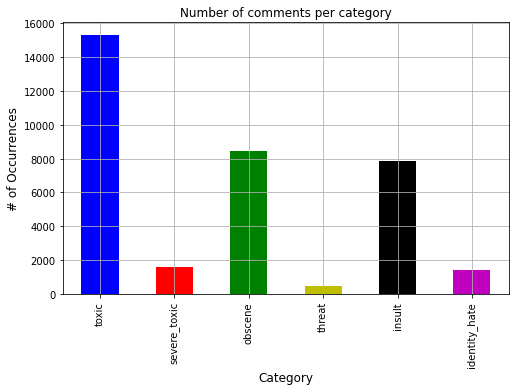

In [42]:
# Getting a histogram of the categories
my_colors = ['b', 'r', 'g', 'y', 'k', 'm']
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5), color=my_colors)

plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
# plt.show()

Text(0.5, 0, '# of categories')

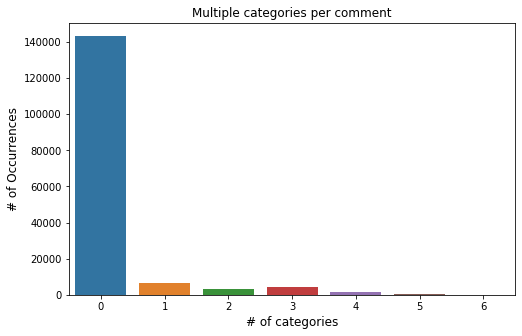

In [17]:
# How many comments have multi-labels?
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of Categories', fontsize=12)

In [18]:
# How many comments are unlabeled
print('Percentage of comments that are not labelled:')
print(len(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]) / len(df))


Percentage of comments that are not labelled:
0.8983211235124177


In [24]:
# Function for cleaning the comment text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

# Use the helper function to clean the text
df['comment_text'] = df['comment_text'].map(lambda comment : clean_text(comment))
# print(df['comment_text'][0])

# Splitting the data into train and test sets
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text
print('train shape is', X_train.shape)
print('test shape is', X_test.shape)

train shape is (106912,)
test shape is (52659,)


In [29]:
# Define a pipeline combining a text feature extractor with multi lable classifier
# 1. Naive Bayes Pipeline
#    This is essentially a Naive Bayes, but we pass the NB model into a OneVsRestClassifier,
#    which is one of the methods we can use for datasets with multiple labels
print('Training Naive Bayes Pipeline')
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Training {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('... ... Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

Training Naive Bayes Pipeline
... Processing toxic
Test accuracy is 0.9192350785240889
... Processing severe_toxic
Test accuracy is 0.9900112041626312
... Processing obscene
Test accuracy is 0.9515752293055318
... Processing threat
Test accuracy is 0.9971135038644866
... Processing insult
Test accuracy is 0.9517271501547694
... Processing identity_hate
Test accuracy is 0.9910556600011394


In [30]:
# Linear SVC
#    This is essentially an SVM, but we pass the SVM into a OneVsRestClassifier,
#    which is one of the methods we can use for datasets with multiple labels
print('Training Linear SVC Pipeline')
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print('... Training {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('... ... Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

Training Linear SVC Pipeline
... Training toxic
... ... Test accuracy is 0.9600068364382157
... Training severe_toxic
... ... Test accuracy is 0.9906948479842003
... Training obscene
... ... Test accuracy is 0.9788830019559809
... Training threat
... ... Test accuracy is 0.9974363356691164
... Training insult
... ... Test accuracy is 0.971135038644866
... Training identity_hate
... ... Test accuracy is 0.9919861752027194


In [31]:
# Logistic Regression Pipeline
#    This is essentially a Logistic Regression model, but we pass the Logistic Regression into a OneVsRestClassifier,
#    which is one of the methods we can use for datasets with multiple labels
print('Training Logistic Regression Pipeline')
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Training {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('... ... Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

Training Logistic Regression Pipeline
... Training toxic
... Test accuracy is 0.9548415275641391
... Training severe_toxic
... Test accuracy is 0.9910746501072941
... Training obscene
... Test accuracy is 0.9760534761389316
... Training threat
... Test accuracy is 0.9973603752444976
... Training insult
... Test accuracy is 0.9687422852693747
... Training identity_hate
... Test accuracy is 0.991758293928863
